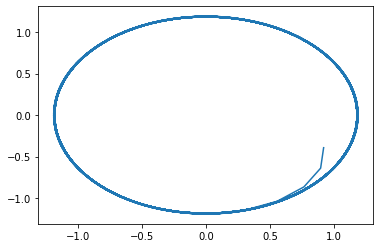

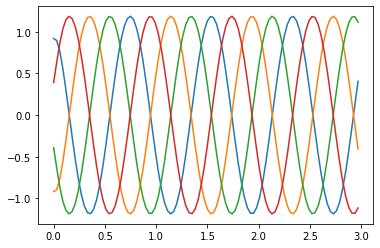

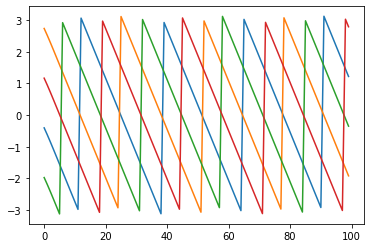

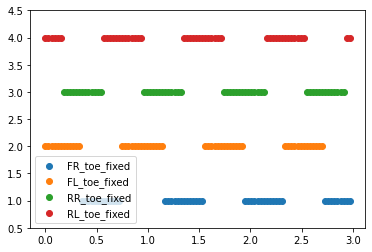

In [122]:
import numpy as np
from blind_walking.envs.utilities.cpg import CPGSystem, CPGParameters

params = CPGParameters(
    a=1.0,
    b=50.0,
    mu=1.0,
    alpha=10.0,
    beta=0.5,
    gamma=50.0,
    period=1 / 1.5,
    dt=0.025,  # 0.025 seconds = 0.001 sim_time_step * 25 action_repeat
)

phase_offsets = {
    "walk": np.array([3 * np.pi / 2, np.pi / 2, np.pi, 0]),
    "trot": np.array([np.pi, 0, 0, np.pi]),
    "pace": np.array([np.pi, 0, np.pi, 0]),
    "bound": np.array([np.pi, np.pi, 0, 0]),
}

foot_contact_fn = {
    "walk": lambda phase: 2 * (phase > 0).astype(int) - 1,
    "trot": lambda phase: 2 * (phase > 0).astype(int) - 1,
    "pace": lambda phase: 2 * (phase > 0).astype(int) - 1,
    "bound": lambda phase: 2 * (phase > 0).astype(int) - 1,
}

cpg_system = CPGSystem(
    params=params,
    coupling_strength=1,
    desired_phase_offsets=phase_offsets['walk'],
    initial_state=CPGSystem.sample_initial_state(phase_offsets['walk']),
)

state_history = np.zeros((1000, 4, 2))
phase_history = np.zeros((1000, 4))
foot_contacts = np.zeros((1000, 4))
for i in range(1000):
    state_history[i] = cpg_system.get_state()
    phase_history[i] = cpg_system.get_phase()
    foot_contacts[i] = foot_contact_fn['walk'](phase_history[i])
    cpg_system.step()

foot_names = ['FR_toe_fixed', 'FL_toe_fixed', 'RR_toe_fixed', 'RL_toe_fixed']
time = np.arange(1000) * 0.03

import matplotlib.pyplot as plt
plt.plot(state_history[:,0,0], state_history[:,0,1])
plt.figure()
for i in range(4):    
    plt.plot(time[:100], state_history[:100, i, 0], label = foot_names[i])

plt.figure()
plt.plot(np.arange(100), phase_history[:100])


plt.figure()
plt.ylim(0.5, 4.5)
for i in range(4):    
    plt.scatter(time[:100], foot_contacts[:100, i] * (i+1), label = foot_names[i])
plt.legend()


# Generate plots of CPG


In [123]:
import numpy as np
from blind_walking.envs.utilities.cpg import CPG, CPGSystem, CPGParameters

def generate_state_history(
    initial_state,
    dt = 0.025,
    n_timesteps = 200,
):
    """ Generate state history from initial state """
    params = CPGParameters(
        a=1.0,
        b=10.0,
        mu=1.0,
        alpha=10.0,
        beta=0.5,
        gamma=50.0,
        period=1 / 1.0,
        dt= dt,  # 0.025 seconds = 0.001 sim_time_step * 25 action_repeat
    )
    cpg = CPG(params, initial_state)

    time = np.arange(n_timesteps) * dt
    state_history = np.zeros((n_timesteps, 2))
    for i in range(n_timesteps):
        state_history[i] = cpg.get_state()
        cpg.step(extrinsic_delta_state=np.zeros(2))
    
    return time, state_history

def plot_state_history(ax, time, state_history):
    xs = state_history[:,0]
    ys = state_history[:,1]
    ax.plot(xs, ys)

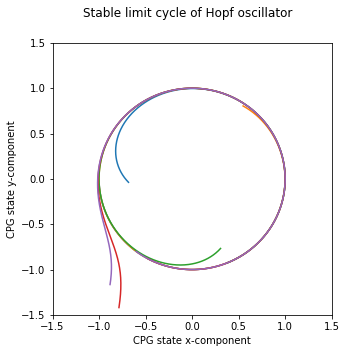

In [124]:
fig, ax = plt.subplots(figsize = (5,5))
ax.set_xlim(-1.5, 1.5)
ax.set_xlabel("CPG state x-component")
ax.set_ylim(-1.5, 1.5)
ax.set_ylabel("CPG state y-component")
fig.suptitle("Stable limit cycle of Hopf oscillator")

for i in range(5):
    initial_state = np.random.uniform(-1.5, 1.5, size=2)
    time, state_history = generate_state_history(initial_state, n_timesteps=1000, dt=0.001)
    plot_state_history(ax, time, state_history)

In [125]:
import numpy as np
from blind_walking.envs.utilities.cpg import CPGSystem, CPGParameters

phase_offsets = {
    "walk": np.array([-np.pi / 2, np.pi / 2, -np.pi, 0]),
    "trot": np.array([np.pi, 0, 0, np.pi]),
    "pace": np.array([np.pi, 0, np.pi, 0]),
    "bound": np.array([np.pi, np.pi, 0, 0]),
}

foot_contact_fn = lambda phase: 2 * (phase > 0).astype(int) - 1
foot_names = ['FR', 'FL', 'RR', 'RL']

def generate_combined_phase_history(
    initial_state,
    gait_name, 
    gait_frequency, 
    duty_factor, 
    dt = 0.025, 
    n_timesteps = 200
):
    """ Generate reference foot contacts for plotting """
    params = CPGParameters(
        a=1.0,
        b=50.0,
        mu=1.0,
        alpha=10.0,
        beta=duty_factor,
        gamma=50.0,
        period=1 / gait_frequency,
        dt= dt,  # 0.025 seconds = 0.001 sim_time_step * 25 action_repeat
    )
    cpg_system = CPGSystem(
        params=params,
        coupling_strength=1,
        desired_phase_offsets=phase_offsets[gait_name],
        initial_state=initial_state
    )

    time = np.arange(n_timesteps) * dt
    state_history = np.zeros((n_timesteps, 4, 2))
    phase_history = np.zeros((n_timesteps, 4))
    foot_contacts = np.zeros((n_timesteps, 4))
    for i in range(n_timesteps):
        state_history[i] = cpg_system.get_state()
        phase_history[i] = cpg_system.get_phase()
        foot_contacts[i] = foot_contact_fn(phase_history[i])
        cpg_system.step()
    
    return time, phase_history

def remap_angle(theta):
    if theta < -np.pi:
        return theta + 2 * np.pi 
    elif theta > np.pi:
        return theta - 2 * np.pi
    else:
        return theta

def plot_combined_phase_history(ax, time, phase_history):
    for i in range(4):
        thetas = phase_history[:,i]
        ax.plot(time, np.cos(thetas), label=foot_names[i])

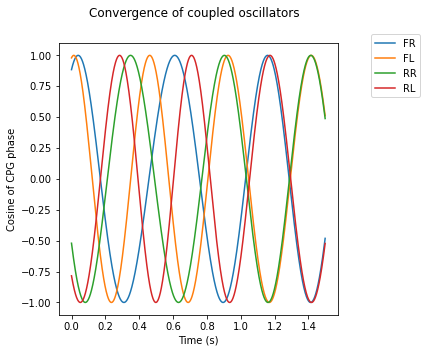

In [126]:
fig, ax = plt.subplots(figsize = (5,5))
ax.set_xlabel("Time (s)")
ax.set_ylim(-1.1, 1.1)
ax.set_ylabel("Cosine of CPG phase")
fig.suptitle("Convergence of coupled oscillators")

initial_state = np.random.uniform(-1.5, 1.5, size=(4,2))
time, state_history = generate_combined_phase_history(initial_state, 'trot', 2.0, 0.5, n_timesteps=1500, dt=0.001)
plot_combined_phase_history(ax, time, state_history)
ax.legend(bbox_to_anchor=(1.1, 1.05))

# Generate plots of Foot Contacts

In [127]:
import numpy as np
from blind_walking.envs.utilities.cpg import CPGSystem, CPGParameters

phase_offsets = {
    "walk": np.array([3 * np.pi / 2, np.pi / 2, np.pi, 0]),
    "trot": np.array([np.pi, 0, 0, np.pi]),
    "pace": np.array([np.pi, 0, np.pi, 0]),
    "bound": np.array([np.pi, np.pi, 0, 0]),
}

foot_contact_fn = lambda phase: 2 * (phase > 0).astype(int) - 1
foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = ['red', 'red', 'blue', 'blue']

def generate_foot_contacts(
    gait_name, 
    gait_frequency, 
    duty_factor, 
    dt = 0.025, 
    n_timesteps = 50
):
    """ Generate reference foot contacts for plotting """
    params = CPGParameters(
        a=1.0,
        b=50.0,
        mu=1.0,
        alpha=10.0,
        beta=duty_factor,
        gamma=50.0,
        period=1 / gait_frequency,
        dt= dt,  # 0.025 seconds = 0.001 sim_time_step * 25 action_repeat
    )
    cpg_system = CPGSystem(
        params=params,
        coupling_strength=1,
        desired_phase_offsets=phase_offsets[gait_name],
        initial_state=CPGSystem.sample_initial_state(phase_offsets[gait_name]),
    )

    time = np.arange(n_timesteps) * dt
    state_history = np.zeros((n_timesteps, 4, 2))
    phase_history = np.zeros((n_timesteps, 4))
    foot_contacts = np.zeros((n_timesteps, 4))
    for i in range(n_timesteps):
        state_history[i] = cpg_system.get_state()
        phase_history[i] = cpg_system.get_phase()
        foot_contacts[i] = foot_contact_fn(phase_history[i])
        cpg_system.step()
    
    return time, foot_contacts

In [128]:
vary_freq_foot_contacts = []
vary_gait_foot_contacts = []
vary_duty_foot_contacts = []
gait_names = ('walk', 'trot', 'pace')
gait_freqs = (1.5, 2.0, 2.5)
duty_factors = (0.25, 0.5, 0.75)

for gf in gait_freqs: 
    _, f = generate_foot_contacts('trot', gf, 0.5)
    name = f"gait-freq-{gf}Hz"
    vary_freq_foot_contacts.append((name, f))

for gn in gait_names: 
    _, f = generate_foot_contacts(gn, 2.0, 0.5)
    name = f"gait-type-{gn}"
    vary_gait_foot_contacts.append((name, f))

for df in duty_factors: 
    _, f = generate_foot_contacts('trot', 2.0, df)
    name = f"duty-factor-{df}"
    vary_duty_foot_contacts.append((name, f))

time = _

/tmp/ipykernel_1177/329849250.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


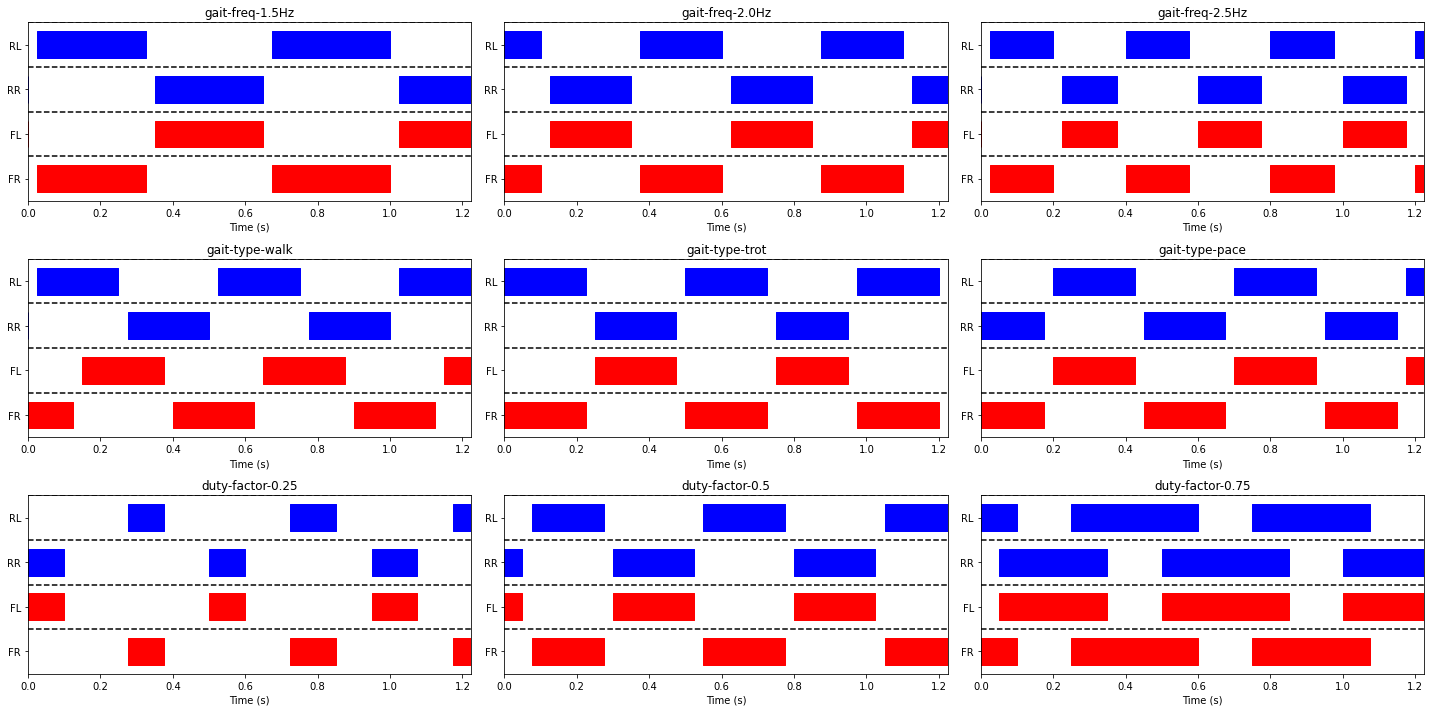

In [135]:
import matplotlib.pyplot as plt

light_gray = (0.3, 0.3, 0.3, 1)
near_black = (0.9, 0.9, 0.9, 1)

def plot_foot_contacts(ax, time, foot_contacts, title):
    
    for i in range(4):
        ax.set_yticks([0,1,2,3])
        ax.set_yticklabels(foot_names)
        ax.set_ylim(-0.5, 3.5)
        ax.set_xlim(0, time[-1])
        ax.set_xlabel("Time (s)")
        # Select timesteps where foot is on ground
        ground_idx = foot_contacts[:,i] == 1
        air_idx = foot_contacts[:,i] != 1

        ax.set_title(title)
        ax.axhline(y=i+0.5, color='black', linestyle='--')
        ax.fill_between(time, i-0.3, i+0.3, where=ground_idx, color = foot_colors[i], alpha=1.0)
        # ax.fill_between(time, i-0.3, i+0.3, where=air_idx, color = foot_colors[i], alpha=0.3)

fig, ax = plt.subplots(3, 3, figsize=(20, 10))
for i, (name, fc) in enumerate(vary_freq_foot_contacts):
    plot_foot_contacts(ax[0,i], time, fc, title = name)
for i, (name, fc) in enumerate(vary_gait_foot_contacts):
    plot_foot_contacts(ax[1,i], time, fc, title = name)
for i, (name, fc) in enumerate(vary_duty_foot_contacts):
    plot_foot_contacts(ax[2,i], time, fc, title = name)
fig.tight_layout()
fig.show()